In [0]:
#                                                                                               Neural network with 5 layers

#
# · · · · · · · · · ·          (input data, flattened pixels)                 X  [minibatch_size, 784]   (784 = 28 * 28)
# \x/x\x/x\x/x\x/x\x/       -- fully connected layer (relu + dropout)         W1 [784, 200]               b1[200]   (200 --> no. of neurons in first layer)
#  · · · · · · · · ·                                                          Z1 [minibatch_size, 200]
#   \x/x\x/x\x/x\x/         -- fully connected layer (relu + dropout)         W2 [200, 100]               b2[100]   (100 --> no. of neurons in second layer)
#    · · · · · · ·                                                            Z2 [minibatch_size, 100]
#     \x/x\x/x\x/           -- fully connected layer (relu + dropout)         W3 [100, 60]                b3[60]    (60 --> no. of neurons in third layer)
#      · · · · ·                                                              Z3 [minibatch_size, 60]
#       \x/x\x/             -- fully connected layer (relu + dropout)         W4 [60, 30]                 b4[30]    (30 --> no. of neurons in fourth layer)
#        · · ·                                                                Z4 [minibatch_size, 30]
#         \x/               -- fully connected layer (softmax)                W5 [30, 10]                 b5[10]    (10 --> output classes (0 to 9))
#          ·                                                                  Z5 [minibatch_size, 10]

In [0]:
# Import libraries
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops

In [3]:
# Load mnist dataset
from tensorflow.examples.tutorials.mnist import input_data as mnist_data
mnist = mnist_data.read_data_sets("data", one_hot=True)

print("\nNo. of training examples: ", mnist.train.images.shape[0])
print("No. of test examples: ", mnist.test.images.shape[0])

print("\nShape of mnist.train.images: ", mnist.train.images.shape)
print("Shape of mnist.train.labels: ", mnist.train.labels.shape)
print("Shape of mnist.test.images: ", mnist.test.images.shape)
print("Shape of mnist.test.labels: ", mnist.test.labels.shape)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz

No. of training examples:  55000
No. of test examples:  10000

Shape of mnist.train.images:  (55000, 784)
Shape of mnist.train.labels:  (55000, 10)
Shape of mnist.test.images:  (10000, 784)
Shape of mnist.test.labels:  (10000, 10)


In [0]:
# Number of neurons in each layer
layer_dims = [784, 200, 100, 60, 30, 10]

# layer_dims[0] = 784 --> (input image size(24 * 24 = 784))
# layer_dims[1] = 200 --> (no. of neurons in first layer)
# layer_dims[2] = 100 --> (no. of neurons in second layer)
# layer_dims[3] = 60 --> (no. of neurons in third layer)
# layer_dims[4] = 30 --> (no. of neurons in fourth layer)
# layer_dims[5] = 10 --> (output classes (0 to 9))

In [0]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- size of an image vector (num_px * num_px = 28 * 28 * 1 = 784)
    n_y -- number of classes (from 0 to 9, so -> 10)
    
    Returns:
    X -- placeholder for the data input, of shape [None, n_x]
    Y -- placeholder for the input labels, of shape [None, n_y]
    keep_prob -- Probability of keeping a node during dropout = 1.0 at test time (no dropout) and 0.75 at training time
    
    None : Because it let's us be flexible on the number of examples.
    """

    X = tf.placeholder(tf.float32, [None, n_x], name = "X")
    Y = tf.placeholder(tf.float32, [None, n_y], name = "Y")
    keep_prob = tf.placeholder(tf.float32)
    
    return X, Y, keep_prob

In [0]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow.
    The shapes are:
                        W1 : [784, 200]
                        b1 : [200]
                        W2 : [200, 100]
                        b2 : [100]
                        W3 : [100, 60]
                        b3 : [60]
                        W4 : [60, 30]
                        b4 : [30]
                        W5 : [30, 10]
                        b5 : [10]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3, W4, b4, W5, b5
    """
    # Random initialization of weights : to break symmetry
    # (if all weights are same, all units in hidden layer will be same too)
    W1 = tf.Variable(tf.truncated_normal([layer_dims[0], layer_dims[1]], stddev = 0.1))
    b1 = tf.Variable(tf.ones([layer_dims[1]]) / 10)

    W2 = tf.Variable(tf.truncated_normal([layer_dims[1], layer_dims[2]], stddev = 0.1))
    b2 = tf.Variable(tf.ones([layer_dims[2]]) / 10)
    
    W3 = tf.Variable(tf.truncated_normal([layer_dims[2], layer_dims[3]], stddev = 0.1))
    b3 = tf.Variable(tf.ones([layer_dims[3]]) / 10)
    
    W4 = tf.Variable(tf.truncated_normal([layer_dims[3], layer_dims[4]], stddev = 0.1))
    b4 = tf.Variable(tf.ones([layer_dims[4]]) / 10)
    
    W5 = tf.Variable(tf.truncated_normal([layer_dims[4], layer_dims[5]], stddev = 0.1))
    b5 = tf.Variable(tf.ones([layer_dims[5]]) / 10)
    
    parameters = {"W1": W1, "b1": b1,
                  "W2": W2, "b2": b2,
                  "W3": W3, "b3": b3,
                  "W4": W4, "b4": b4,
                  "W5": W5, "b5": b5}
    
    return parameters

In [0]:
def forward_propagation_with_dropout(X, parameters, keep_prob):
    """
    Implements forward propagation
    
    Arguments:
    X -- input dataset placeholder, of shape (number of examples, input_size)
    parameters -- python dictionary containing parameters "W1", "b1", "W2", "b2", "W3", "b3", "W4", "b4", "W5", "b5"

    Returns:
    Z5 -- the output of softmax layer
    YLogits -- weighted sum + bias of last layer
    """
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    W4 = parameters['W4']
    b4 = parameters['b4']
    
    W5 = parameters['W5']
    b5 = parameters['b5']
    
    Z1 = tf.add(tf.matmul(X, W1), b1)
    A1 = tf.nn.relu(Z1)
    d1 = tf.nn.dropout(A1, keep_prob)
    
    Z2 = tf.add(tf.matmul(d1, W2), b2)
    A2 = tf.nn.relu(Z2)
    d2 = tf.nn.dropout(A2, keep_prob)

    Z3 = tf.add(tf.matmul(d2, W3), b3)
    A3 = tf.nn.relu(Z3)
    d3 = tf.nn.dropout(A3, keep_prob)
    
    Z4 = tf.add(tf.matmul(d3, W4), b4)
    A4 = tf.nn.relu(Z4)
    d4 = tf.nn.dropout(A4, keep_prob)
    
    YLogits = tf.add(tf.matmul(d4, W5), b5)
    Z5      = tf.nn.softmax(YLogits)
     
    return Z5, YLogits

In [0]:
def compute_cost(YLogits, Y):
    """
    Computes the cost
    
    Arguments:
    YLogits -- weighted sum + bias of last layer
    Y -- "true" labels vector placeholder, same shape as YLogits(Z5)
    
    Returns:
    cross_entropy - Tensor of the cost function
    """
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits = YLogits, labels = Y)
    cross_entropy = tf.reduce_mean(cross_entropy) * 100
    
    return cross_entropy

In [0]:
def model(lr_min, lr_max, decay_speed, num_epochs, minibatch_size, print_epoch_results = True):
    """
    Implements a five-layer tensorflow neural network
    
    Arguments:
    lr_min -- minimum value of learning rate(final value)
    lr_max -- maximum value of learning rate(initial value)
    decay_speed -- speed at which learning rate to be decreased
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_epoch_results -- True to print the cost and accuracies every 10 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (m, n_x) = mnist.train.images.shape               # (m : number of examples in the train set, n_x : input size)
    n_y = mnist.train.labels.shape[1]                 # n_y : output size
    costs = []                                        # To keep track of the cost
    train_acc = []                                    # To keep track of the training set accuracy
    test_acc = []                                     # To keep track of the test set accuracy
    num_minibatches = int(m / minibatch_size) + 1     # number of minibatches of size minibatch_size in the train set

    # Create Placeholders of shape (n_x, n_y)
    X, Y, keep_prob = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z5, YLogits = forward_propagation_with_dropout(X, parameters, keep_prob)
    
    # Calculate the correct predictions
    correct_prediction = tf.equal(tf.argmax(Z5, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(YLogits, Y)
    
    # Placeholder for learning rate
    lr = tf.placeholder(tf.float32)
    
    # Backpropagation: AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):
            
            learning_rate = lr_min + (lr_max - lr_min) * math.exp(-epoch / decay_speed)

            epoch_cost = 0.                                                  # Defines a cost related to an epoch

            for i in range(num_minibatches):

                # Get minibatch
                minibatch_X, minibatch_Y = mnist.train.next_batch(minibatch_size)
                train_data = {X: minibatch_X, Y: minibatch_Y}                
                
                # Run the session to execute the "optimizer" and the "cost".
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y, lr : learning_rate, keep_prob : 0.7})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Get train and test set accuracy for every epoch
            epoch_train_acc = accuracy.eval(session = sess, feed_dict = {X: mnist.train.images, Y: mnist.train.labels, keep_prob : 1.0})
            epoch_test_acc = accuracy.eval(session = sess, feed_dict = {X: mnist.test.images, Y: mnist.test.labels, keep_prob : 1.0})
            
            costs.append(epoch_cost)
            train_acc.append(epoch_train_acc)
            test_acc.append(epoch_test_acc)
            
            # Print the cost
            if print_epoch_results == True and epoch % 10 == 0:
                print ("epoch %i: cost = %f, training accuracy = %f, test accuracy = %f" % (epoch, epoch_cost, epoch_train_acc, epoch_test_acc))
                
        print("")
        # Plot cost
        plt.subplot(1, 3, 1)
        plt.plot(costs)
        plt.ylabel("cost")
        plt.xlabel("epochs")
        plt.title("keep_prob(dropout) = 0.7")
        
        # Plot train accuracy
        plt.subplot(1, 3, 2)
        plt.plot(np.squeeze(train_acc))
        plt.ylabel("Training set accuracy")
        plt.xlabel("epochs")
        plt.title("keep_prob(dropout) = 0.7")

        # Plot test accuracy
        plt.subplot(1, 3, 3)
        plt.plot(np.squeeze(test_acc))
        plt.ylabel("Test set accuracy")
        plt.xlabel("epochs")
        plt.title("keep_prob(dropout) = 0.7")
        
        plt.subplots_adjust(top = 0.92, bottom = 0.08, left = 0.8, right = 3, hspace = 0.25, wspace = 0.8)
        plt.show()
        
        # Save the parameters in a variable
        parameters = sess.run(parameters)
        print("Parameters have been trained!")

        print("\nFinal Accuracy:\n")
        
        # Calculate accuracy on the train set
        print("Train Accuracy:", accuracy.eval(session = sess, feed_dict = {X: mnist.train.images, Y: mnist.train.labels, keep_prob : 1.0}))
        
        # Calculate accuracy on the test set
        print("Test Accuracy:", accuracy.eval(session = sess, feed_dict = {X: mnist.test.images, Y: mnist.test.labels, keep_prob : 1.0}))
        
        return parameters

epoch 0: cost = 53.385720, training accuracy = 0.951709, test accuracy = 0.948700
epoch 10: cost = 11.314670, training accuracy = 0.986727, test accuracy = 0.978100
epoch 20: cost = 7.494873, training accuracy = 0.993909, test accuracy = 0.979400
epoch 30: cost = 5.253722, training accuracy = 0.997564, test accuracy = 0.981300
epoch 40: cost = 3.824650, training accuracy = 0.998582, test accuracy = 0.981800
epoch 50: cost = 2.998171, training accuracy = 0.999182, test accuracy = 0.982000
epoch 60: cost = 2.759134, training accuracy = 0.999582, test accuracy = 0.982500
epoch 70: cost = 2.111688, training accuracy = 0.999618, test accuracy = 0.982000
epoch 80: cost = 1.915878, training accuracy = 0.999636, test accuracy = 0.982100
epoch 90: cost = 1.431159, training accuracy = 0.999745, test accuracy = 0.982400



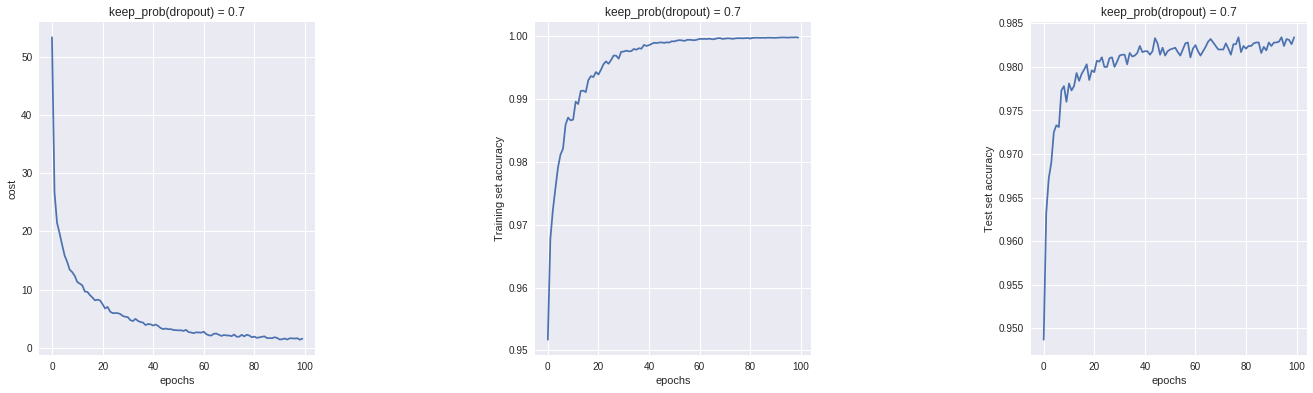

Parameters have been trained!

Final Accuracy:

Train Accuracy: 0.9998
Test Accuracy: 0.9834


In [10]:
parameters = model(lr_min = 0.0001, lr_max = 0.003, decay_speed = 30,  num_epochs = 100, minibatch_size = 64)